# Final Notebook 

Lorela Blaka <br>Allison Gao <br>Raylin Soriano

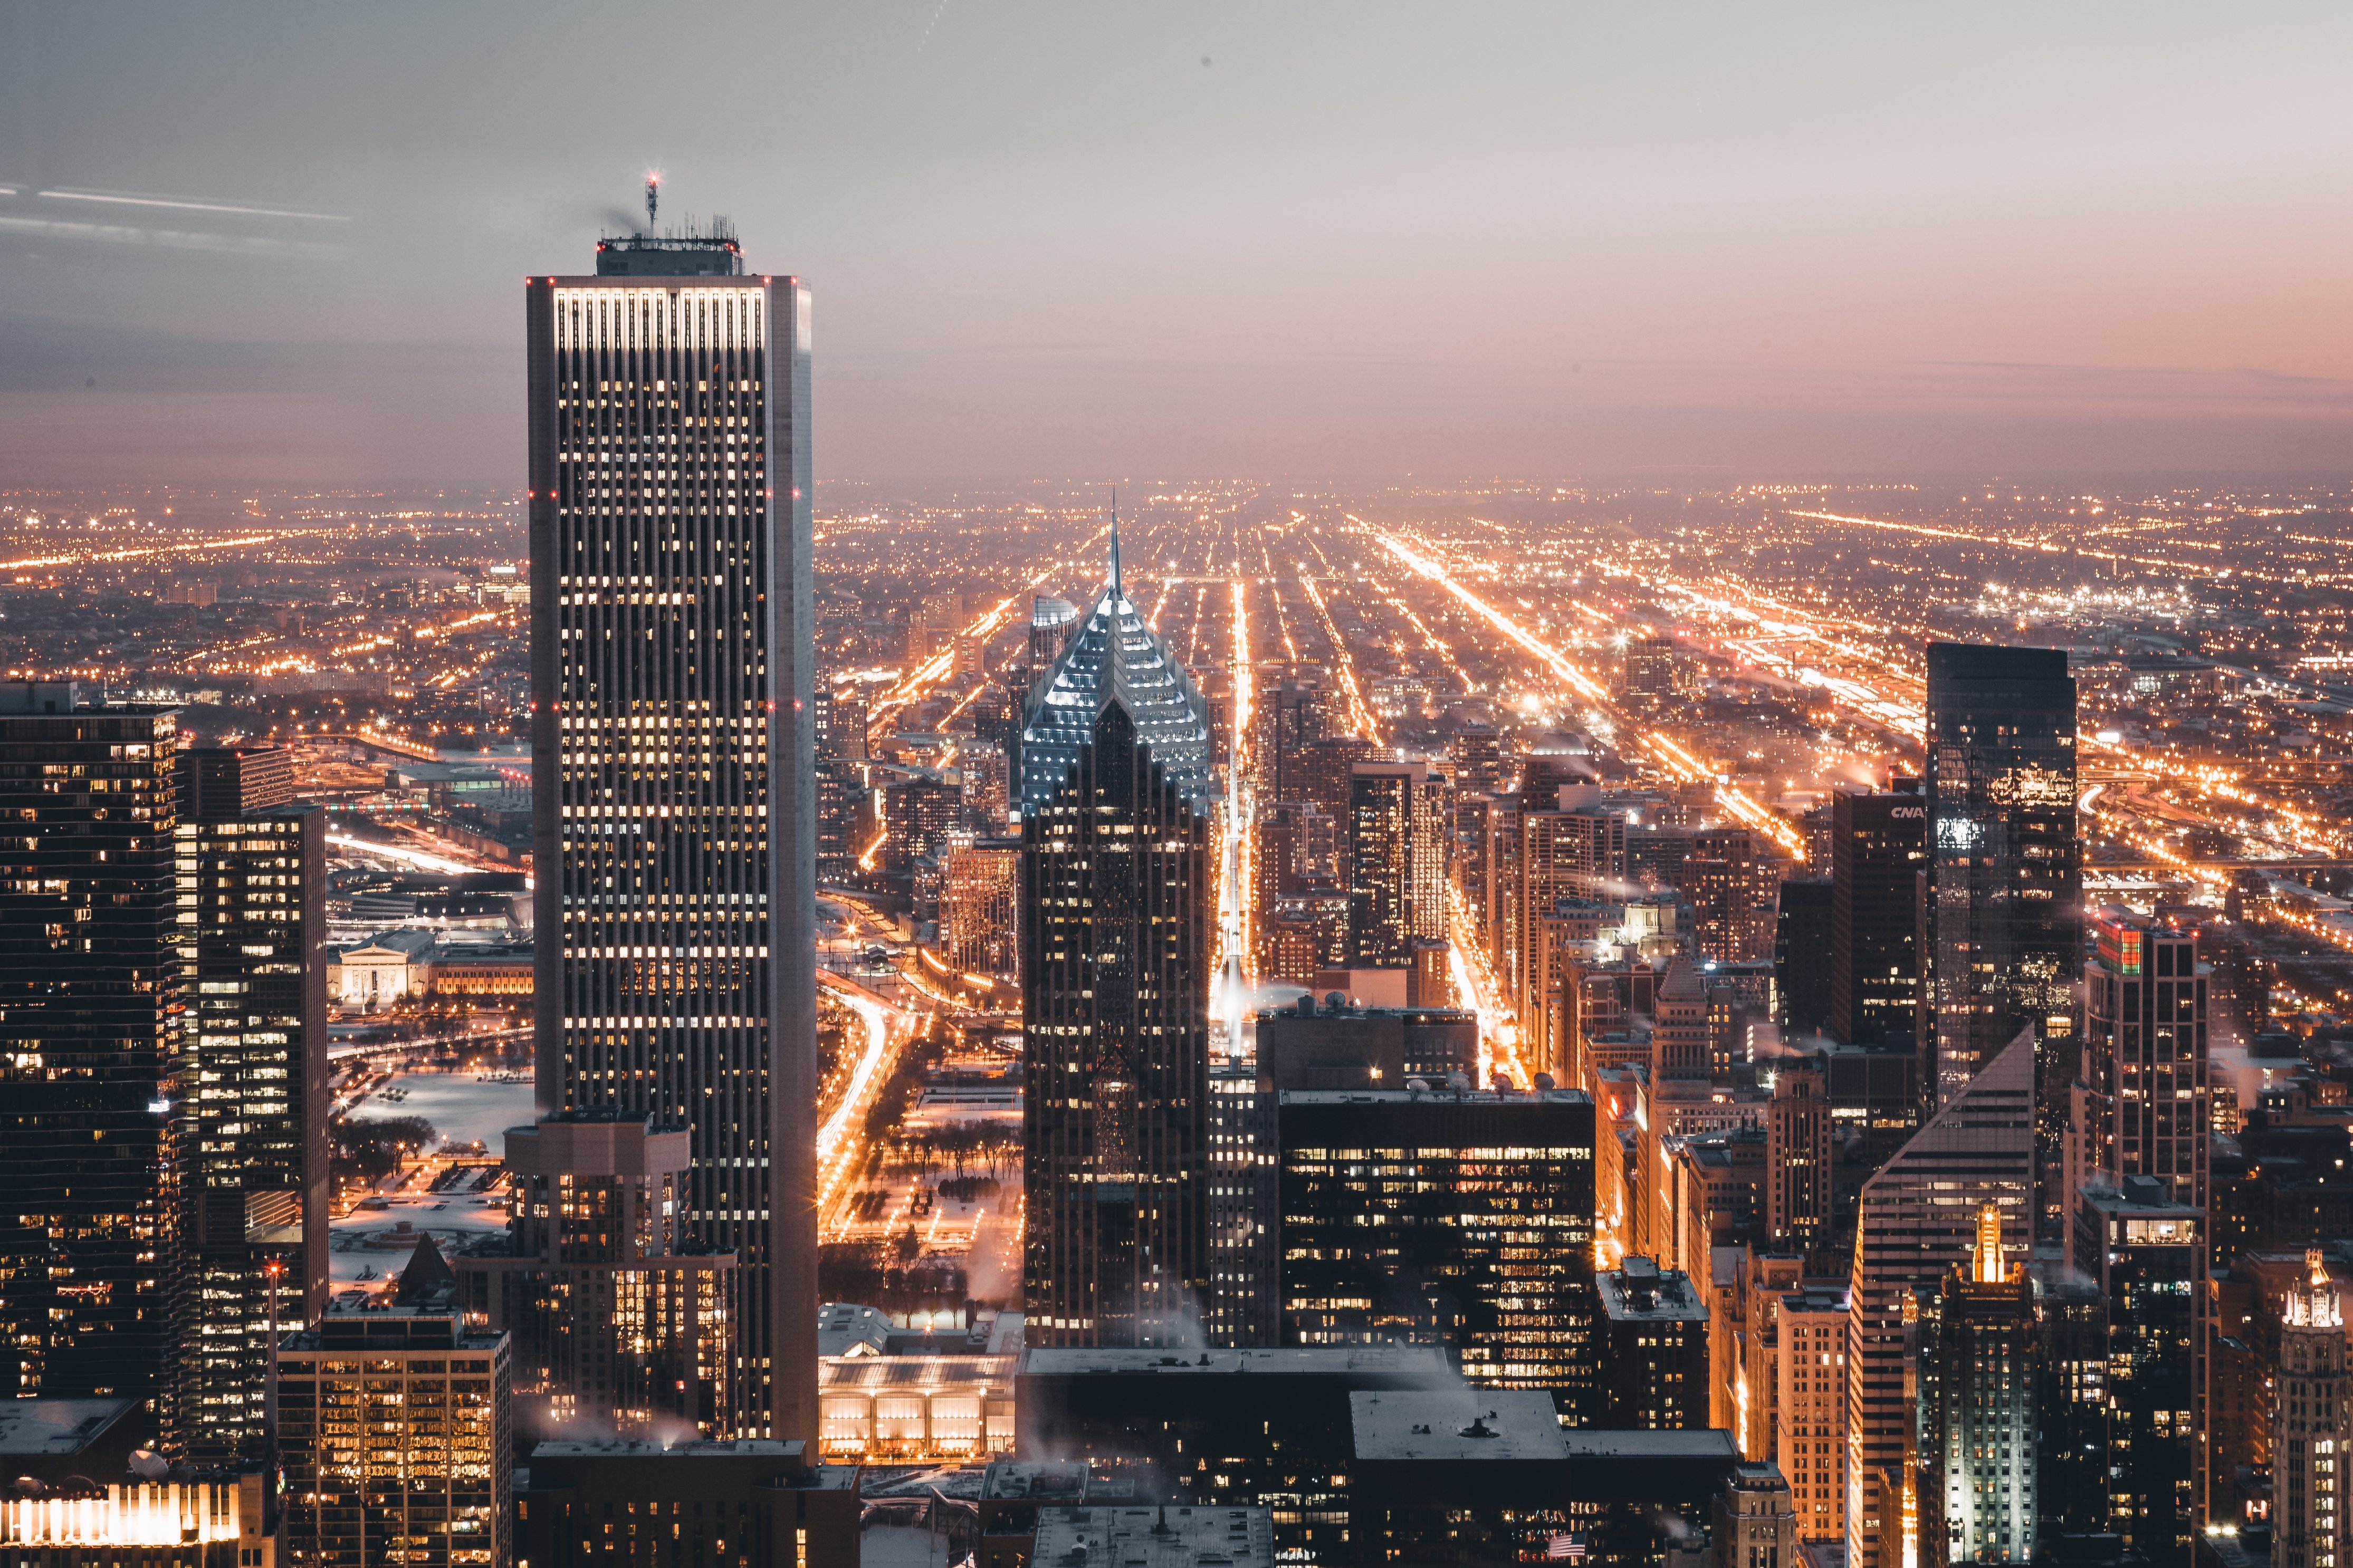

**The purpose of this project is to help the Chicago's Department of Transportation(DOT) increase safety on the roads. This analysis uses data on 2019 Chicago car crashes to predict different levels of injury with respect to a myriad of factors such as airbag deployment and road defect. Specifically, we split level of injury into mild, medium, and severe, making our target variable a ternary class.**

In [283]:
import pandas as pd 
import numpy as np 
import csv  
import matplotlib.pyplot as plt 
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
import descartes


from collections import Counter
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier


from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier

import datetime as datetime

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate

In [218]:
crashes_data = pd.read_csv('data/Traffic_Crashes_-_Crashes.csv')

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [219]:
crashes_data.drop(crashes_data.columns[np.r_[1,2,5,10:13,15,17:20,21,24:35,36:43,48]], axis=1, inplace=True)

In [220]:
people_data = pd.read_csv('data/Traffic_Crashes_-_People.csv')

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [221]:
people_data = pd.read_csv('data/Traffic_Crashes_-_People.csv')
people_data.drop(people_data.columns[np.r_[3:10,11,12,13,17:30]], axis=1, inplace=True)

In [222]:
vehicles_data = pd.read_csv('data/Traffic_Crashes_-_Vehicles.csv')

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [223]:
vehicles_data.drop(vehicles_data.columns[np.r_[0,2:13,16,18:38,39:72]], axis=1, inplace=True)


Merge the 3 dataframes into one main `df`

In [293]:
people_crashes_data = crashes_data.merge(people_data, on='CRASH_RECORD_ID')
df = people_crashes_data.merge(vehicles_data, on='CRASH_RECORD_ID')


Check and drop duplicates

In [294]:
df.duplicated().sum()

73592

In [295]:
df.drop_duplicates(inplace=True)

Check and handle nulls

In [296]:
df.isna().sum()

CRASH_RECORD_ID                0
CRASH_DATE                     0
POSTED_SPEED_LIMIT             0
DEVICE_CONDITION               0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
FIRST_CRASH_TYPE               0
ROADWAY_SURFACE_COND           0
ROAD_DEFECT                    0
CRASH_TYPE                     0
DAMAGE                         0
PRIM_CONTRIBUTORY_CAUSE        0
SEC_CONTRIBUTORY_CAUSE         0
MOST_SEVERE_INJURY            20
CRASH_HOUR                     0
CRASH_DAY_OF_WEEK              0
CRASH_MONTH                    0
LATITUDE                   14085
LONGITUDE                  14085
PERSON_ID                      0
PERSON_TYPE                    0
SEX                        37492
SAFETY_EQUIPMENT            7374
AIRBAG_DEPLOYED            46602
EJECTION                   30258
VEHICLE_DEFECT             54423
VEHICLE_TYPE               54423
VEHICLE_USE                54423
MANEUVER                   54423
FIRST_CONTACT_POINT        70587
dtype: int

In [297]:
df['LATITUDE'].fillna(df['LATITUDE'].mean(), inplace=True )
df['LONGITUDE'].fillna(df['LONGITUDE'].mean(), inplace=True )

Modify `MOST_SEVERE_INJURY`, which is our dependent variable

In [298]:
df['MOST_SEVERE_INJURY'] = df['MOST_SEVERE_INJURY'].map({'NO INDICATION OF INJURY': 'mild', 
                                                                         'REPORTED, NOT EVIDENT': 'mild',
                                                                         'NONINCAPACITATING INJURY': 'medium',
                                                                         'INCAPACITATING INJURY': 'severe',
                                                                         'FATAL': 'severe'})


In [299]:
df.dropna(subset=['MOST_SEVERE_INJURY'], inplace=True)

In [300]:
df['SEX'].fillna('X', inplace=True)

df['SEX'] = df['SEX'].map({'M': 'M', 
                           'F': 'F',
                           'X': 'Unknown'})
df['SEX'].value_counts()

M          1277919
F           928875
Unknown     248453
Name: SEX, dtype: int64

In [301]:
df['SAFETY_EQUIPMENT'].fillna('USAGE UNKNOWN', inplace=True)
df['AIRBAG_DEPLOYED'].fillna('DEPLOYMENT UNKNOWN', inplace=True)
df['EJECTION'].fillna('UNKNOWN', inplace=True)
df['VEHICLE_DEFECT'].fillna('UNKNOWN', inplace=True)
df['VEHICLE_TYPE'].fillna('UNKNOWN/NA', inplace=True)
df['VEHICLE_USE'].fillna('UNKNOWN/NA', inplace=True)
df['MANEUVER'].fillna('UNKNOWN/NA', inplace=True)
df['FIRST_CONTACT_POINT'].fillna('UNKNOWN', inplace=True)


In [302]:
df.isnull().sum()

CRASH_RECORD_ID            0
CRASH_DATE                 0
POSTED_SPEED_LIMIT         0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
CRASH_TYPE                 0
DAMAGE                     0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
MOST_SEVERE_INJURY         0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
LATITUDE                   0
LONGITUDE                  0
PERSON_ID                  0
PERSON_TYPE                0
SEX                        0
SAFETY_EQUIPMENT           0
AIRBAG_DEPLOYED            0
EJECTION                   0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
MANEUVER                   0
FIRST_CONTACT_POINT        0
dtype: int64

In [303]:
df['CRASH_DATE'] = df['CRASH_DATE'].map(lambda x: datetime.datetime.strptime(x[0:10], "%m/%d/%Y"))
df['CRASH_DATE']

0         2019-07-10
1         2019-07-10
2         2019-07-10
3         2019-07-10
4         2019-07-10
             ...    
2528853   2021-07-12
2528854   2021-07-12
2528855   2021-07-12
2528856   2021-07-13
2528857   2021-07-13
Name: CRASH_DATE, Length: 2455247, dtype: datetime64[ns]

Filter for only 2019 data

In [304]:
df= df[df["CRASH_DATE"].isin(pd.date_range("2019-01-01", "2020-01-01"))]

**Feature Engineer `accident_count` and `accident_risk` by area using `longitude` and `latitude`**

Create `geometry` column in `geo_df` that specifies the points of `longitude` and `latitude` as values 

In [307]:
crs = {'init': 'epsg:4326'}
geo = [Point(xy) for xy in zip( df['LONGITUDE'], df['LATITUDE'])]
print(geo[:3])





geo_df = gpd.GeoDataFrame(df, crs=crs,  geometry=geo )
geo_df = geo_df[geo_df['LONGITUDE'] != 0.0]


[<shapely.geometry.point.Point object at 0x7fa7b406b070>, <shapely.geometry.point.Point object at 0x7fa916b1ca60>, <shapely.geometry.point.Point object at 0x7fa90392f4f0>]


/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


We want to see if there is a visual relationship if injuries are prominent in certain parts of Chicago, to gain an understanding of whether there is a relationship between these two variables. 

We will bring in the street map

<AxesSubplot:>

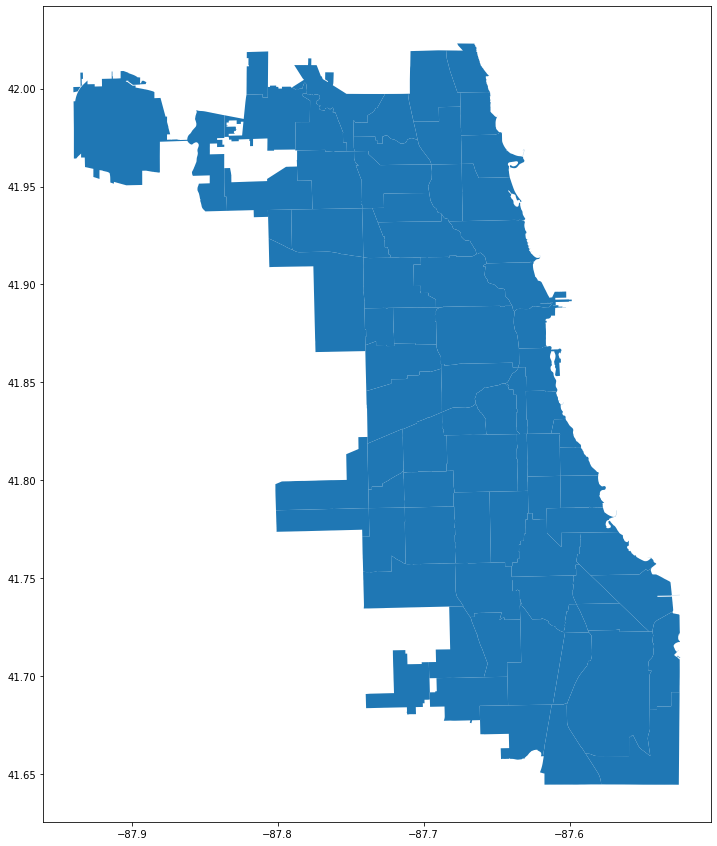

In [285]:
street_map = gpd.read_file('data/street_center_lines/geo_export_1cf411cc-3964-4b23-a824-9e05b1386235.shp')
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)

We will now graph where the most severe injuries are occuring.

<AxesSubplot:>

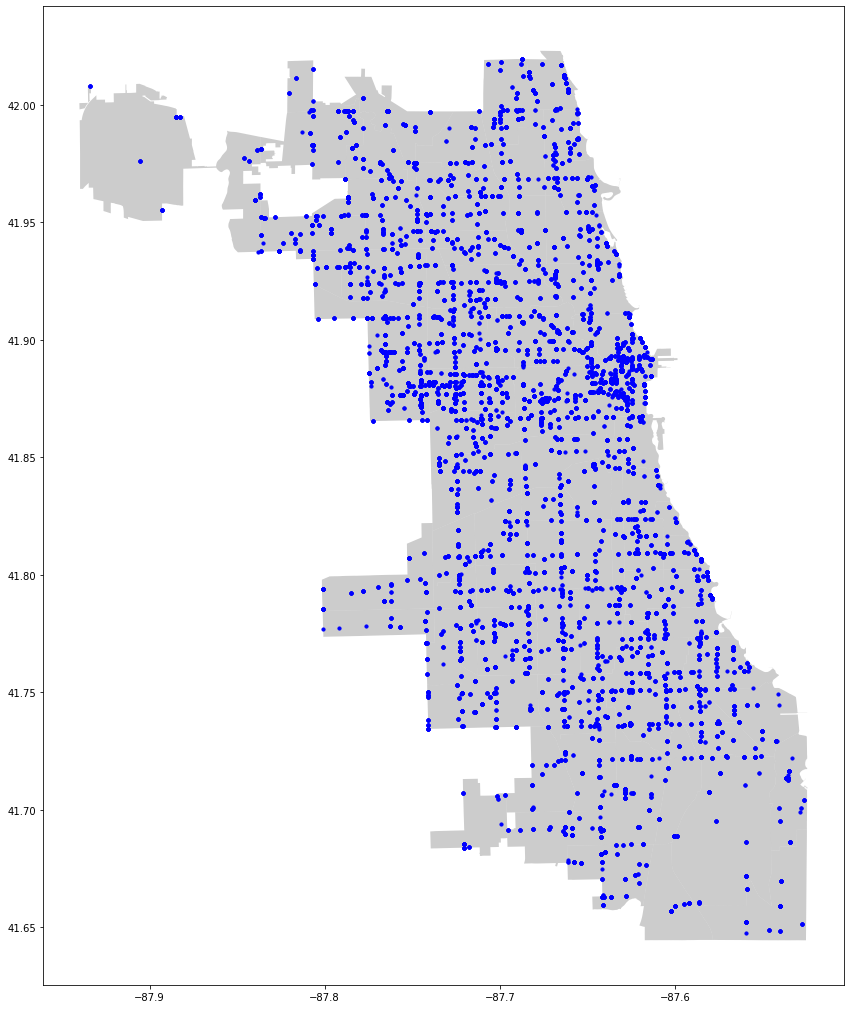

In [309]:
fig, ax = plt.subplots(figsize = (18,18))
street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['MOST_SEVERE_INJURY'] == 'severe'].plot(ax = ax, 
                                                        markersize = 10, 
                                                        color = 'blue', 
                                                        marker = 'o', 
                                                        label = 'severe')



# plt.legend(prop = {'size':15})



There are clear hotspots where severe level of injuries occur, so we we will continue to feature engineer `longitude` and `latitude` 

Below, we are binning `latitude` and `longitude` by value of `.01`, roughly .5 square miles

In [310]:
step  = 0.01
to_bin = lambda x: np.floor(x / step ) * step 
geo_df["latbin"] = geo_df['LATITUDE'].map(to_bin)
geo_df["latbin"]
geo_df["lonbin"] = geo_df['LONGITUDE'].map(to_bin)

geo_bin = [Point(xy) for xy in zip( geo_df["lonbin"], geo_df["latbin"])]
geo_df_bin = gpd.GeoDataFrame(geo_df, crs=crs,  geometry=geo_bin )

geo_bin = pd.DataFrame(geo_df[["lonbin","latbin"]].value_counts())
geo_bin.reset_index(inplace=True)


/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Then we calculate accident count per zone which we defined by binning above

In [311]:
geo_bin['accident_count'] = geo_bin[0] 
geo_bin['accident_prob'] = 100*(geo_bin['accident_count']/geo_bin['accident_count'].sum())
print(geo_bin['accident_count'].quantile(.8) )     
print(geo_bin['accident_count'].quantile(.6) )     
print(geo_bin['accident_count'].quantile(.4) )     
print(geo_bin['accident_count'].quantile(.2) )     

1229.0
816.0
466.0
167.0


Based on the printed quantiles, we can use `label_zones(accident_count)` to label `accident_risk` on a scale of 1-5

In [312]:
def label_zones(accident_count):
    if accident_count > 1229.0:
        return 5
    if accident_count < 1229.0 and accident_count > 816.0:
        return 4
    if accident_count < 816.0 and accident_count > 466.0:
        return 3
    if accident_count < 466.0 and accident_count > 167.0:
        return 2
    if accident_count < 167.0:
        return 1  
    
geo_bin['accident_risk'] = geo_bin['accident_count'].map(lambda x: label_zones(x))


df_map = geo_df.merge(geo_bin, how = 'left', on = ['lonbin','latbin'])
geo_bin

,lonbin,latbin,0,accident_count,accident_prob,accident_risk
0,-87.63,41.89,7732,7732,1.423341,5.0
1,-87.63,41.88,7511,7511,1.382658,5.0
2,-87.64,41.89,6484,6484,1.193603,5.0
3,-87.64,41.88,6338,6338,1.166727,5.0
4,-87.68,41.85,5547,5547,1.021116,5.0
...,...,...,...,...,...,...
691,-87.94,42.00,4,4,0.000736,1.0
692,-87.58,41.69,4,4,0.000736,1.0
693,-87.64,41.95,3,3,0.000552,1.0
694,-87.70,41.71,2,2,0.000368,1.0


In [313]:
df = geo_df.merge(geo_bin, how = 'left', on = ['lonbin','latbin'])
df.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 543229 entries, 0 to 543228
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          543229 non-null  object        
 1   CRASH_DATE               543229 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT       543229 non-null  int64         
 3   DEVICE_CONDITION         543229 non-null  object        
 4   WEATHER_CONDITION        543229 non-null  object        
 5   LIGHTING_CONDITION       543229 non-null  object        
 6   FIRST_CRASH_TYPE         543229 non-null  object        
 7   ROADWAY_SURFACE_COND     543229 non-null  object        
 8   ROAD_DEFECT              543229 non-null  object        
 9   CRASH_TYPE               543229 non-null  object        
 10  DAMAGE                   543229 non-null  object        
 11  PRIM_CONTRIBUTORY_CAUSE  543229 non-null  object        
 12  SEC_CONT

In [314]:
df.drop(df.columns[np.r_[3:6,7,9:13,17:23,24:34,35]], axis=1, inplace=True)
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 543229 entries, 0 to 543228
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CRASH_RECORD_ID     543229 non-null  object        
 1   CRASH_DATE          543229 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT  543229 non-null  int64         
 3   FIRST_CRASH_TYPE    543229 non-null  object        
 4   ROAD_DEFECT         543229 non-null  object        
 5   MOST_SEVERE_INJURY  543229 non-null  object        
 6   CRASH_HOUR          543229 non-null  int64         
 7   CRASH_DAY_OF_WEEK   543229 non-null  int64         
 8   CRASH_MONTH         543229 non-null  int64         
 9   AIRBAG_DEPLOYED     543229 non-null  object        
 10  accident_count      543229 non-null  int64         
 11  accident_risk       540551 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 53.9+ MB


# Train Test Split

In [242]:
X = df.drop(["MOST_SEVERE_INJURY","CRASH_RECORD_ID", "CRASH_DATE"], axis=1)
X.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 543229 entries, 0 to 543228
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   POSTED_SPEED_LIMIT  543229 non-null  int64  
 1   FIRST_CRASH_TYPE    543229 non-null  object 
 2   ROAD_DEFECT         543229 non-null  object 
 3   CRASH_HOUR          543229 non-null  int64  
 4   CRASH_DAY_OF_WEEK   543229 non-null  int64  
 5   CRASH_MONTH         543229 non-null  int64  
 6   AIRBAG_DEPLOYED     543229 non-null  object 
 7   accident_count      543229 non-null  int64  
 8   accident_risk       540551 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 41.4+ MB


In [243]:
df['MOST_SEVERE_INJURY'] = df['MOST_SEVERE_INJURY'].map({'mild': 0, 
                                                         'medium': 1,
                                                         'severe': 2})
y = df['MOST_SEVERE_INJURY']

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 42, stratify=y)

In [245]:
y.value_counts()

0    473724
1     56285
2     13220
Name: MOST_SEVERE_INJURY, dtype: int64

In [246]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [247]:
X_train['AIRBAG_DEPLOYED'].fillna('DEPLOYMENT UNKNOWN', inplace=True)
X_train['accident_risk'].fillna(4, inplace=True)
X_train['accident_count'].fillna(X_train['accident_count'].mean(), inplace=True)

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [248]:
X_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 380260 entries, 469268 to 307969
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   POSTED_SPEED_LIMIT  380260 non-null  int64  
 1   FIRST_CRASH_TYPE    380260 non-null  object 
 2   ROAD_DEFECT         380260 non-null  object 
 3   CRASH_HOUR          380260 non-null  int64  
 4   CRASH_DAY_OF_WEEK   380260 non-null  int64  
 5   CRASH_MONTH         380260 non-null  int64  
 6   AIRBAG_DEPLOYED     380260 non-null  object 
 7   accident_count      380260 non-null  int64  
 8   accident_risk       380260 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 29.0+ MB


# One Hot Encode

One hot encode training data

In [249]:
categoricals = ['ROAD_DEFECT',
                'FIRST_CRASH_TYPE', 
                'AIRBAG_DEPLOYED']

train_dummies = X_train[categoricals]

# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')
enc = ohe.fit(train_dummies)
train_dummies_trans = enc.transform(train_dummies)

# Dummies values in matrix form
train_data = train_dummies_trans.todense()

# New dummy column names
names = ohe.get_feature_names(categoricals)

# Make them into Dataframe
train_dummies_trans_df = pd.DataFrame(train_data, columns=names,index = X_train.index)


One hot encode test data

In [251]:
categoricals = ['ROAD_DEFECT',
                'FIRST_CRASH_TYPE', 
                'AIRBAG_DEPLOYED']
test_dummies = X_test[categoricals]
# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')

# Transform the dataset into dummies matrix
enc = ohe.fit(test_dummies)
test_dummies_trans = enc.transform(test_dummies)

# Dummies values in matrix form
test_data = test_dummies_trans.todense()

# New dummy column names
names = ohe.get_feature_names(categoricals)

# Make them into Dataframe
test_dummies_trans_df = pd.DataFrame(test_data, columns=names,index = X_test.index)


Merge training categorical data back with training numerical data so it can be used for modeling

In [252]:
numerical = X_train.select_dtypes(exclude='object') 
numerical = pd.DataFrame(numerical, index = X_train.index)
train_df = train_dummies_trans_df.merge(numerical, left_index = True , right_index=True)



Merge test categorical data back with test numerical data so it can be used for modeling

In [253]:
numerical_test = X_test.select_dtypes(exclude='object') 
numerical_test = pd.DataFrame(numerical_test, index = X_test.index)
test_df = test_dummies_trans_df.merge(numerical_test, left_index = True , right_index=True)
test_df


,ROAD_DEFECT_DEBRIS ON ROADWAY,ROAD_DEFECT_NO DEFECTS,ROAD_DEFECT_OTHER,"ROAD_DEFECT_RUT, HOLES",ROAD_DEFECT_SHOULDER DEFECT,ROAD_DEFECT_UNKNOWN,ROAD_DEFECT_WORN SURFACE,FIRST_CRASH_TYPE_ANGLE,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,...,"AIRBAG_DEPLOYED_DEPLOYED, SIDE",AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_DID NOT DEPLOY,AIRBAG_DEPLOYED_NOT APPLICABLE,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,accident_count,accident_risk
46791,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,30,15,5,3,1037,4.0
11638,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,30,22,7,8,1944,5.0
344488,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,10,10,4,11,1857,5.0
191775,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,15,17,2,3,951,4.0
62167,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,30,6,4,6,465,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,25,1,7,9,834,4.0
314986,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,30,17,5,3,506,3.0
275834,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,25,22,1,5,886,4.0
248660,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,10,16,1,5,3735,5.0


# SMOTE on training data

To handle class imbalance, we will use the SMOTE technique to oversample our minority class

In [254]:
counter = Counter(y_train)
print(counter)

Counter({0: 331607, 1: 39399, 2: 9254})


In [255]:
from collections import Counter
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(train_df, y_train)


In [256]:
# summarize the new class distribution
counter = Counter(y_train_sm)
print(counter)


Counter({0: 331607, 1: 331607, 2: 331607})


# Baseline Model

In [257]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train_sm, y_train_sm)
y_hat = dummy_model.predict(train_df)

Model Validation: 

In [258]:
acc = accuracy_score(y_train,y_hat)
macro_precision_score=precision_score(y_train, y_hat, average='macro')
micro_precision_score=precision_score(y_train , y_hat, average='micro')
macro_recall_score=recall_score(y_train, y_hat, average='macro')
micro_recall_score=recall_score(y_train, y_hat, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score: 0.8720533319307842
Macro Precision Score: 0.29068444397692805
Micro Precision Score: 0.8720533319307842
Macro Recall Score: 0.3333333333333333
Micro Recall Score: 0.8720533319307842


These are our baseline scores, and next we will try a Logistic Model to see if there is any improvement. We are most interested in the Accuracy Score and Macro Precision Score because we are predicting a ternary system. This means an F1 score doesn't make sense and recall scores are less meaningful for the purpose of our analysis. 

# Logistic Model

We ran the following GridSearch for Logistic Regression to find the optimal hyperparameter values. 

The resulting hyperparameter values were then used to run the below Logistic Regression: 

In [206]:
logreg = LogisticRegression(multi_class='multinomial', 
                             C=0.0001, 
                             class_weight =None, 
                             tol=0.0001,
                             max_iter=10000000)

logreg.fit(X_train_sm, y_train_sm)
y_hat = logreg.predict(train_df)



Model Validation: 

In [211]:
acc = accuracy_score(y_train,y_hat)
macro_precision_score=precision_score(y_train, y_hat, average='macro')
micro_precision_score=precision_score(y_train, y_hat, average='micro')
macro_recall_score=recall_score(y_train, y_hat, average='macro')
micro_recall_score=recall_score(y_train, y_hat, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))


/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score: 0.8720533319307842
Macro Precision Score: 0.29068444397692805
Micro Precision Score: 0.8720533319307842
Macro Recall Score: 0.3333333333333333
Micro Recall Score: 0.8720533319307842


As the results show, our scores for the Logistic model have not improved. We will now try random forest.

# Random Forest

In [ ]:
cv_results = cross_validate(logreg, train_df, y_train, return_train_score=True)
print('Mean Test Score: {}'.format(cv_results['test_score'].mean()))
print('Mean Train Score: {}'.format(cv_results['train_score'].mean()))

We ran the following GridSearch for Random Forest to find the optimal hyperparameter values. 

In [259]:
# random forest for feature importance on a regression problem

# define the model
ran_for = RandomForestClassifier(n_estimators = 25,
                              max_depth = 20, 
                              min_samples_leaf = 1)

# fit the model
ran_for.fit(X_train_sm, y_train_sm)
y_hat = ran_for.predict(train_df)


Model Validation: 

In [261]:
acc = accuracy_score(y_train,y_hat)
macro_precision_score=precision_score(y_train, y_hat, average='macro')
micro_precision_score=precision_score(y_train, y_hat, average='micro')
macro_recall_score=recall_score(y_train, y_hat, average='macro')
micro_recall_score=recall_score(y_train, y_hat, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

Accuracy Score: 0.9245305843370325
Macro Precision Score: 0.7690428672178663
Micro Precision Score: 0.9245305843370325
Macro Recall Score: 0.780399044686502
Micro Recall Score: 0.9245305843370325


These scores are much better, which indicates that using an ensemble method (i.e. enhanced decision tree model) might be best for modeling our data. Another model we can try of this type is XGBClassifier.  

# XG Boost

We ran the following GridSearch for XGBClassifier to find the optimal hyperparameter values. 

Based on our model validation scores when we run XGBC, we can tweak any of the below parameters: 

In [152]:
estimator = XGBClassifier()
print(estimator.get_params('self').keys())
print(gridsearch.best_params_)

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])
{'model__max_depth': 20, 'model__min_child_weight': 0.5, 'model__objective': 'ternary:logistic', 'model__reg_alpha': 0}


**Model Deployment on Training Data**

Based on our GridSearch results, we will run XGBClassifier with the optimal parameters below: 

In [198]:
boost_model = XGBClassifier(objective='ternary:logistic',
    max_depth = 20,
    min_child_weight = 0.5,
    reg_alpha = 0)


boost_model.fit(X_train_sm, y_train_sm)
print("fit model")
    
y_hat = boost_model.predict(train_df)
print("predicted on model")
    
acc = accuracy_score(y_train,y_hat)
macro_precision_score=precision_score(y_train, y_hat, average='macro')
micro_precision_score=precision_score(y_train, y_hat, average='micro')
macro_recall_score=recall_score(y_train, y_hat, average='macro')
micro_recall_score=recall_score(y_train, y_hat, average='micro')
    
print('Score: {}'.format(boost_model.score(train_df, y_train)))
print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

[12:54:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fit model
predicted on model
Score: 0.999066428233314
Accuracy Score: 0.999066428233314
Macro Precision Score: 0.9963320351344002
Micro Precision Score: 0.999066428233314
Macro Recall Score: 0.9989983951389027
Micro Recall Score: 0.999066428233314


Confusion Matrix:


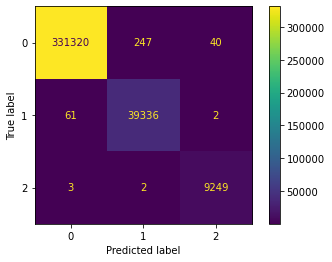

In [199]:
xgboost_matrix = plot_confusion_matrix(boost_model,train_df, y_train)
print('Confusion Matrix:\n', xgboost_matrix)
 
    
pyplot.show()

Using only `max_depth` and `min_child_weight` as paraemeters leads to an overfitted model. To control for this we will introduce randomness using a `gamma` hyperparameter.

In [200]:
boost_model = XGBClassifier(objective='ternary:logistic',
    max_depth = 20,
    min_child_weight = 0.5,
    gamma = 10)


boost_model.fit(X_train_sm, y_train_sm)
print("fit model")
    
y_hat = boost_model.predict(train_df)
print("predicted on model")
    
acc = accuracy_score(y_train,y_hat)
macro_precision_score=precision_score(y_train, y_hat, average='macro')
micro_precision_score=precision_score(y_train, y_hat, average='micro')
macro_recall_score=recall_score(y_train, y_hat, average='macro')
micro_recall_score=recall_score(y_train, y_hat, average='micro')
    
print('Score: {}'.format(boost_model.score(train_df, y_train)))
print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:04:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fit model
predicted on model
Score: 0.9715194866670173
Accuracy Score: 0.9715194866670173
Macro Precision Score: 0.9275581713624229
Micro Precision Score: 0.9715194866670173
Macro Recall Score: 0.9379738504988477
Micro Recall Score: 0.9715194866670173


Based on these results, we ultimately moved forward with XGBC as the best performing model since the Accuracy Score and the Macro Precision Score were the highest between the 3 models. After some hypertuning, we are going to next look at the predictive accuracy for each of the classes of injury. 

**XGBoost confusion matrix for training data**

Confusion Matrix:


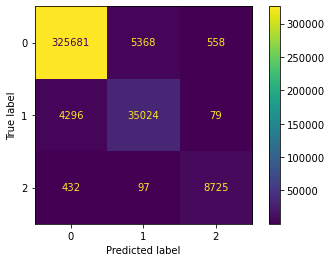

In [201]:
xgboost_matrix = plot_confusion_matrix(boost_model,train_df, y_train)
print('Confusion Matrix:\n', xgboost_matrix)

pyplot.show()

In [ ]:
precision_0 = 325681/(325681+432+4296)
print('Precision for Mild Injuries: {}'.format(precision_0))

precision_1 = 35024/(5368+35024+97)
print('Precision for Medium Injuries: {}'.format(precision_1))

precision_2 = 8725/(8725+79+558)
print('Precision for Severe Injuries: {}'.format(precision_2))


XGBoost confusion matrix suggests that our model is good at predicting level 2 (most severe) injuries on training data.

**Model Deployment on Test Data**

We now will perform model validation on the testing data and compare the result with the training data.

In [203]:
boost_model = XGBClassifier(objective='ternary:logistic',
    max_depth = 20,
    min_child_weight = 0.5,
    gamma = 10)


boost_model.fit(X_train_sm, y_train_sm)
print("fit model")
    
y_hat_test = boost_model.predict(test_df)
print("predicted on model")
    
acc = accuracy_score(y_test,y_hat_test)
macro_precision_score=precision_score(y_test, y_hat_test, average='macro')
micro_precision_score=precision_score(y_test, y_hat_test, average='micro')
macro_recall_score=recall_score(y_test, y_hat_test, average='macro')
micro_recall_score=recall_score(y_test, y_hat_test, average='micro')
    
print('Score: {}'.format(boost_model.score(test_df, y_test)))
print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fit model
predicted on model
Score: 0.9488246230878266
Accuracy Score: 0.9488246230878266
Macro Precision Score: 0.8690309066631038
Micro Precision Score: 0.9488246230878266
Macro Recall Score: 0.8414581447925965
Micro Recall Score: 0.9488246230878266


We are most interested in the Accuracy Score and Macro Precision Score. The accuracy score for training is .028 higher than testing, and macro precision for training is .058 higher than testing. We have modified different `gamma` scores and settled on 10 as the optimal value. 

In [ ]:
xgboost_matrix = plot_confusion_matrix(boost_model,test_df, y_test)
print('Confusion Matrix:\n', xgboost_matrix)

pyplot.show()

In [ ]:
precision_0 = 138495/(138495+3656+667)
print('Precision for Mild Injuries: {}'.format(precision_0))

precision_1 = 13053/(13053+3242+218)
print('Precision for Medium Injuries: {}'.format(precision_1))

precision_2 = 3081/(3081+177+380)
print('Precision for Severe Injuries: {}'.format(precision_2))


XGBoost confusion matrix suggests that our model is good at predicting level 2 (most severe) injuries on validation data. 

# Visualizations

**Accident Likelihood by Area**

<AxesSubplot:title={'center':'Accident Likelihood by Area'}>

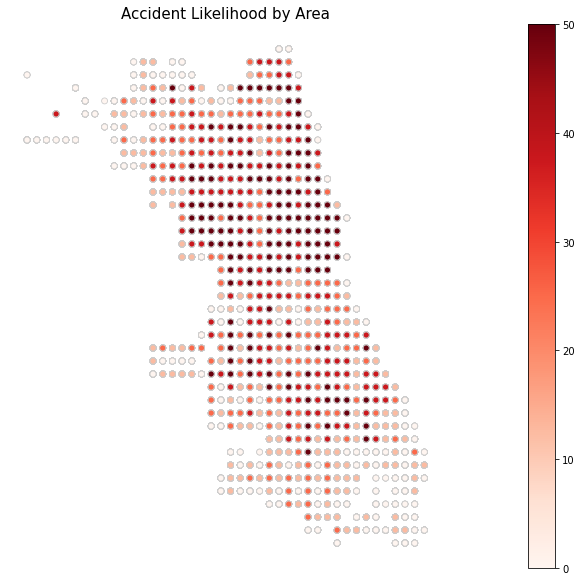

In [263]:
# set the value column that will be visualised
variable = 'accident_risk'
# set the range for the choropleth values
vmin, vmax = 0, 50
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))

# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Accident Likelihood by Area', fontdict={'fontsize': '15', 'fontweight' : '3'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) 

# add the colorbar to the figure
fig.colorbar(sm)
# create map
df_map.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

This map shows the accident likelihood per area in Chicago. This was defined above by increments of ~0.5 square miles. 

**Accidents by Defect Type**

Text(0.5, 0, 'Road Defect')

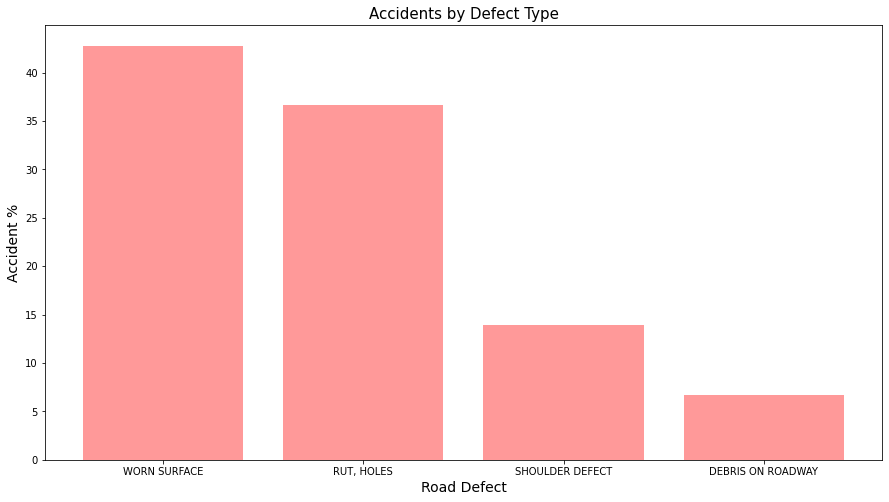

In [315]:
df_graph = pd.DataFrame.copy(geo_df)
 

df_graph['injury_level'] = df_graph['MOST_SEVERE_INJURY'].map({'mild': 0, 
                                                         'medium': 1,
                                                         'severe': 2})
df_graph = df_graph[(df_graph['ROAD_DEFECT']!='NO DEFECTS')
                   & (df_graph['ROAD_DEFECT']!='OTHER') 
                    & (df_graph['ROAD_DEFECT']!='UNKNOWN')
                   &(df_graph['injury_level']==2)]



df_graph = df_graph.groupby('ROAD_DEFECT')['CRASH_RECORD_ID'].count()/1.80
df_graph = pd.DataFrame(df_graph)
df_graph.reset_index(inplace=True)
df_graph.sort_values(by="CRASH_RECORD_ID",ascending = False, inplace=True)




fig, ax = plt.subplots(figsize = (15,8))

x = df_graph['ROAD_DEFECT']
h = df_graph['CRASH_RECORD_ID'] 
ax.bar(x,h, alpha = 0.4, color = 'red')
ax.set_title("Accidents by Defect Type", fontsize=15)
ax.set_ylabel("Accident %", fontsize=14)
ax.set_xlabel("Road Defect", fontsize=14)

This graph shows the percent of accidents by defect type. Results show that the roads with worn surfaces and rut and holes had some of the highest percentages 

**Accident Count by Airbag State**

Text(0, 0.5, 'Accident Count')

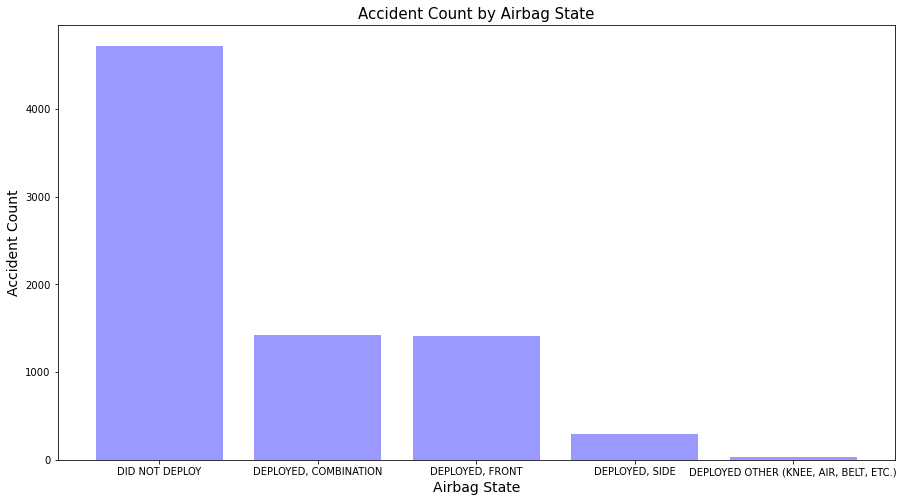

In [316]:
df_graph1 = pd.DataFrame.copy(geo_df)
 
df_graph1['injury_level'] = df_graph1['MOST_SEVERE_INJURY'].map({'mild': 0, 
                                                         'medium': 1,
                                                         'severe': 2})
df_graph1 = df_graph1[(df_graph1['injury_level']==2)
                     &(df_graph1['AIRBAG_DEPLOYED']!='NOT APPLICABLE')
                     &(df_graph1['AIRBAG_DEPLOYED']!='DEPLOYMENT UNKNOWN')]


df_graph1 = df_graph1.groupby('AIRBAG_DEPLOYED')['CRASH_RECORD_ID'].count()
df_graph1 = pd.DataFrame(df_graph1)
df_graph1.reset_index(inplace=True)
df_graph1.sort_values(by="CRASH_RECORD_ID",ascending = False, inplace=True)


fig, ax = plt.subplots(figsize = (15,8))

x = df_graph1['AIRBAG_DEPLOYED']
h = df_graph1['CRASH_RECORD_ID']
ax.bar(x,h, alpha = 0.4, color = 'blue', )
ax.set_title("Accident Count by Airbag State", fontsize=15)
ax.set_xlabel("Airbag State", fontsize=14)
ax.set_ylabel("Accident Count", fontsize=14)

This graph shows the accident count for most severe injuries was highest when the airbag was not deployed